In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../../"))

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1"

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

print_backend_info()

DESC version=0.14.1+371.g6a626f49a.
Using JAX backend: jax version=0.5.0, jaxlib version=0.5.0, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.61 GB available memory.


In [5]:
def plot_field_lines(field, equ, ntransit=200, nrho=9, size=0.4, outside=False):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    if outside:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, 2))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
        rmax = np.max(r0)
        rmin = np.min(r0)
        r0 = np.linspace(rmin, rmax + (rmax-rmin)*0.05, nrho)
        z0 = np.zeros_like(r0)
    else:
        grid_trace = LinearGrid(rho=np.linspace(0, 1, nrho))
        r0 = equ.compute("R", grid=grid_trace)["R"]
        z0 = equ.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(equ)
    fig, ax = poincare_plot(
        field,
        r0,
        z0,
        NFP=equ.NFP,
        ax=ax,
        color="k",
        size=size,
        ntransit=ntransit,
        bounds_R=(0.5, 1.5),
        bounds_Z=(-0.7, 0.7),
    )
    return fig, ax

def plot_init_coils_modular(equ, ncoils=3, r_over_a=3.5):
    coilset = initialize_modular_coils(
        equ, num_coils=ncoils, r_over_a=r_over_a
    ).to_FourierXYZ()
    fig = plot_3d(equ, "|B|")
    fig = plot_coils(coilset, fig=fig)
    return fig

In [6]:
def optimize_coils(equ, coilset0=None, curvature=True):
    if coilset0 is None:
        coilset0 = initialize_modular_coils(
            equ, num_coils=3, r_over_a=3.5
        ).to_FourierXYZ()
    # define our objective function (we will use a helper function here to make it easier to change weights later)
    weights = {
        "quadratic flux": 500,
        "coil-coil min dist": 100,
        "plasma-coil min dist": 10,
        "coil curvature": 250,
        "coil length": 20,
    }
    coil_grid = LinearGrid(N=50)
    # similarly define a grid on the plasma surface where B*n errors will be evaluated
    plasma_grid = LinearGrid(M=25, N=25, NFP=equ.NFP, sym=equ.sym)
    objs = [
        QuadraticFlux(
            equ,
            field=coilset0,
            # grid of points on plasma surface to evaluate normal field error
            eval_grid=plasma_grid,
            field_grid=coil_grid,
            vacuum=True,  # vacuum=True means we won't calculate the plasma contribution to B as it is zero
            weight=weights["quadratic flux"],
            bs_chunk_size=10,
        ),
        CoilLength(
            coilset0,
            bounds=(0, 2 * np.pi * (coilset0[0].compute("length")["length"])),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=weights["coil length"],
        ),
    ]
    if curvature:
        objs += [
            CoilCurvature(
                coilset0,
                bounds=(-1, 2),
                normalize_target=False,  # we're giving bounds in normalized units
                grid=coil_grid,
                weight=weights["coil curvature"],
            )
        ]
    obj = ObjectiveFunction(objs)
    coil_indices_to_fix_current = [False for c in coilset0]
    coil_indices_to_fix_current[0] = True
    constraints = (FixCoilCurrent(coilset0, indices=coil_indices_to_fix_current),)

    optimizer = Optimizer("lsq-exact")

    (optimized_coilset,), _ = optimizer.optimize(
        coilset0,
        objective=obj,
        constraints=constraints,
        maxiter=200,
        verbose=3,
        ftol=1e-6,
        xtol=0,
        copy=True,
    )
    return optimized_coilset

In [7]:
def optimize_coils_regcoil(surf, equ, num_coils=16, return_k=False):
    # create the FourierCurrentPotentialField object from the constant offset surface we found in the previous cell
    surface_current_field = FourierCurrentPotentialField.from_surface(
        surf,
        I=0,
        # manually setting G to value needed to provide the equilibrium's toroidal flux,
        # though this is not necessary as it gets set automatically inside the solve_regularized_surface_current function
        G=np.asarray(
            [
                -equ.compute("G", grid=LinearGrid(rho=np.array(1.0)))["G"][0]
                / mu_0
                * 2
                * np.pi
            ]
        ),
        # set symmetry of the current potential, "sin" is usually expected for stellarator-symmetric surfaces and equilibria
        sym_Phi="sin",
    )

    surface_current_field.change_Phi_resolution(M=12, N=12)

    # create the evaluation grid (where Bn will be minimized on plasma surface)
    # and source grid (discretizes the source K for Biot-Savart and where |K| will be penalized on winding surface)
    Megrid = 20
    Negrid = 20
    Msgrid = 20
    Nsgrid = 20

    eval_grid = LinearGrid(M=Megrid, N=Negrid, NFP=equ.NFP, sym=False)
    # ensure that sym=False for source grid so the field evaluated from the surface current is accurate
    # (i.e. must evaluate source over whole surface, not just the symmetric part)
    # NFP>1 is ok, as we internally will rotate the source through the field periods to sample entire winding surface
    sgrid = LinearGrid(M=Msgrid, N=Nsgrid, NFP=equ.NFP, sym=False)

    lambda_regularization = np.append(np.array([0]), np.logspace(-30, 1, 20))

    # solve_regularized_surface_current method runs the REGCOIL algorithm
    fields, data = solve_regularized_surface_current(
        surface_current_field,  # the surface current field whose geometry and Phi resolution will be used
        eq=equ,  # the Equilibrium object to minimize Bn on the surface of
        source_grid=sgrid,  # source grid
        eval_grid=eval_grid,  # evaluation grid
        current_helicity=(
            1*surface_current_field.NFP,
            -1,
        ),  # pair of integers (M_coil, N_coil), determines topology of contours (almost like  QS helicity),
        #  M_coil is the number of times the coil transits poloidally before closing back on itself
        # and N_coil is the toroidal analog (if M_coil!=0 and N_coil=0, we have modular coils, if both M_coil
        # and N_coil are nonzero, we have helical coils)
        # we pass in an array to perform scan over the regularization parameter (which we call lambda_regularization)
        # to see tradeoff between Bn and current complexity
        lambda_regularization=lambda_regularization,
        # lambda_regularization can also be just a single number in which case no scan is performed
        vacuum=True,  # this is a vacuum equilibrium, so no need to calculate the Bn contribution from the plasma currents
        regularization_type="regcoil",
        chunk_size=40,
    )
    surface_current_field = fields[
        0
    ]  # fields is a list of FourierCurrentPotentialField objects

    if return_k:
        return surface_current_field
    else:
        coilset = surface_current_field.to_CoilSet(num_coils=num_coils, stell_sym=True)
        return coilset

In [8]:
def solve_poincare(eq2solve, fix_lambda=True, **kwargs):
    jac_chunk_size = kwargs.pop("jac_chunk_size", None)
    constraints = get_fixed_xsection_constraints(eq2solve, fix_lambda=fix_lambda)
    objective = ObjectiveFunction(ForceBalance(eq2solve, jac_chunk_size=jac_chunk_size))
    eq2solve.solve(constraints=constraints, objective=objective, verbose=3, **kwargs)

In [9]:
eq = desc.io.load("eq-org/eq-org-landreman2021-island-L8M8N8.h5")
coil_grid = LinearGrid(N=50)
plasma_grid = LinearGrid(M=25, N=25, NFP=eq.NFP, sym=eq.sym)
plot_grid = LinearGrid(M=20, N=40, NFP=1, endpoint=True)

# Do all of the above for different Resolutions

In [10]:
def all_above(equ):
    print(f"\n\nSOLVING POINCARE FOR L={equ.L} M={equ.M} N={equ.N}\n\n")
    equ._xsection = equ.get_surface_at(zeta=0)
    eqp = equ.copy()
    upres = 12
    eqp.change_resolution(
        L=upres, M=upres, N=upres, L_grid=2 * upres, M_grid=2 * upres, N_grid=2 * upres
    )
    eqp.solve(maxiter=1000, ftol=5e-4, xtol=0, verbose=3)
    eqp.surface = eqp.get_surface_at(rho=1)
    eqp.save(f"eq-p2lcfs{upres}-landreman2021-island-L{equ.L}M{equ.M}N{equ.N}.h5")
    plot_comparison(
        eqs=[equ, eqp],
        labels=[
            f"poincare L{equ.L}M{equ.M}N{equ.N}",
            f"resolve lcfs{upres} L{eqp.L}M{eqp.M}N{eqp.N}",
        ],
    )
    plt.savefig(
        f"plot-landreman2021-surface-compare-p2lcfs{upres}-L{equ.L}M{equ.M}N{equ.N}.png",
        dpi=1000,
    )
    regcoil = 1
    return_k = 1
    if regcoil:
        # create the constant offset surface
        surf2 = eqp.surface.constant_offset_surface(
            offset=0.25,  # desired offset
            M=16,  # Poloidal resolution of desired offset surface
            N=16,  # Toroidal resolution of desired offset surface
            grid=LinearGrid(M=32, N=32, NFP=eqp.NFP),
        )  # grid of points on base surface to evaluate unit normal and find points on offset surface,
        # generally should be twice the desired resolution
        if return_k:
            optimized_coilset2 = optimize_coils_regcoil(
                surf2, eqp, num_coils=8, return_k=True
            )
        else:
            optimized_coilset2 = optimize_coils_regcoil(surf2, eqp, num_coils=8)
    else:
        coilset0 = initialize_modular_coils(
            eqp, num_coils=3, r_over_a=4
        ).to_FourierXYZ()
        optimized_coilset2 = optimize_coils(eqp, coilset0=coilset0, curvature=True)
    optimized_coilset2.save(
        f"surface-K-p2lcfs10-landreman2021-L{equ.L}M{equ.M}N{equ.N}.h5"
    )
    fig, ax = plot_field_lines(
        optimized_coilset2, eqp, nrho=18, ntransit=200, size=0.2, outside=False
    )
    fig.suptitle(f"Field Line Trace after P2LCFS{upres} L={equ.L} M={equ.M} N={equ.N}")
    fig.savefig(
        f"plot-landreman2021-p2lcfs{upres}-L{equ.L}M{equ.M}N{equ.N}.png", dpi=1000
    )
    fig, ax = plot_1d(equ, "iota", linecolor="b", label="Poincare")
    fig, ax = plot_1d(eqp, "iota", ax=ax, linecolor="r", label=f"P2LCFS{upres}")
    fig.suptitle(f"L={equ.L}M={equ.M}N={equ.N}")

    plot_boozer_surface(equ)
    plt.title(f"Poincare with L={equ.L}M={equ.M}N={equ.N}")
    plot_boozer_surface(eqp)
    plt.title(f"After P2LCFS{upres} L={eqp.L}M={eqp.M}N={eqp.N}")



SOLVING POINCARE FOR L=3 M=3 N=4


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 683 ms
Timer: Objective build = 1.15 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 659 ms
Timer: LinearConstraintProjection build = 5.27 sec
Number of parameters: 2784
Number of objectives: 16562
Timer: Initializing the optimization = 7.58 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.160e-06                                    4.873e-04   
       1  

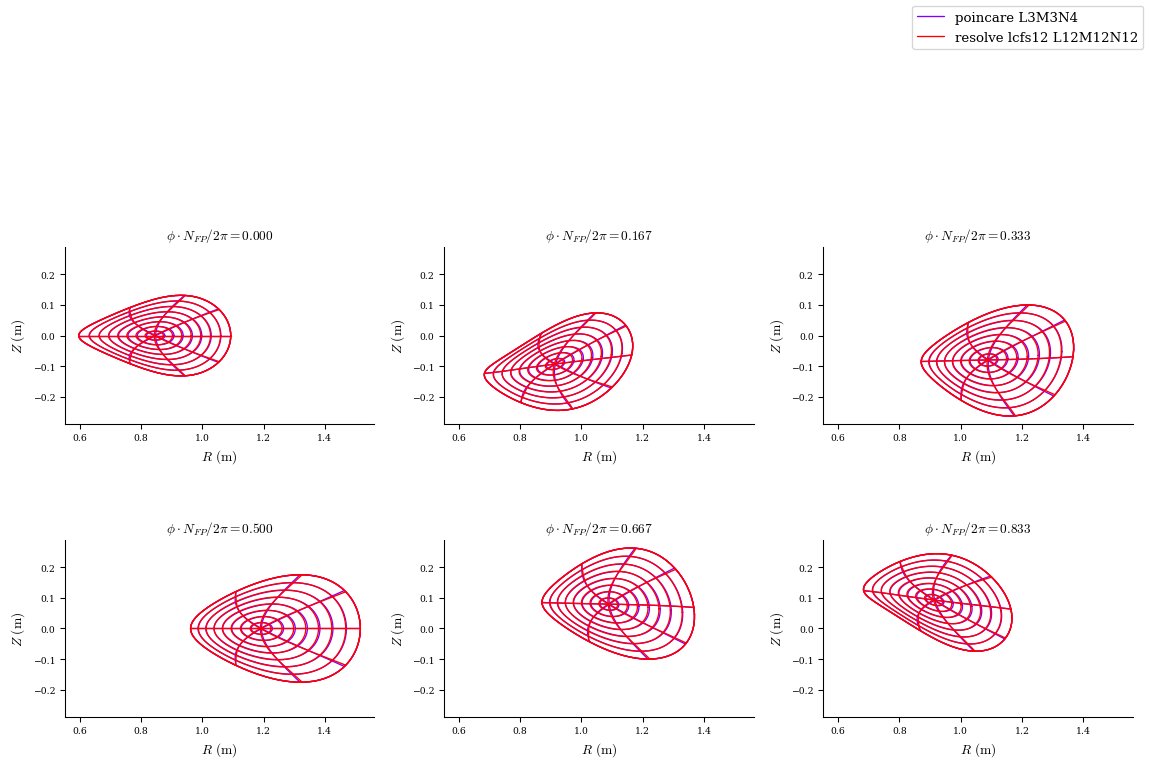

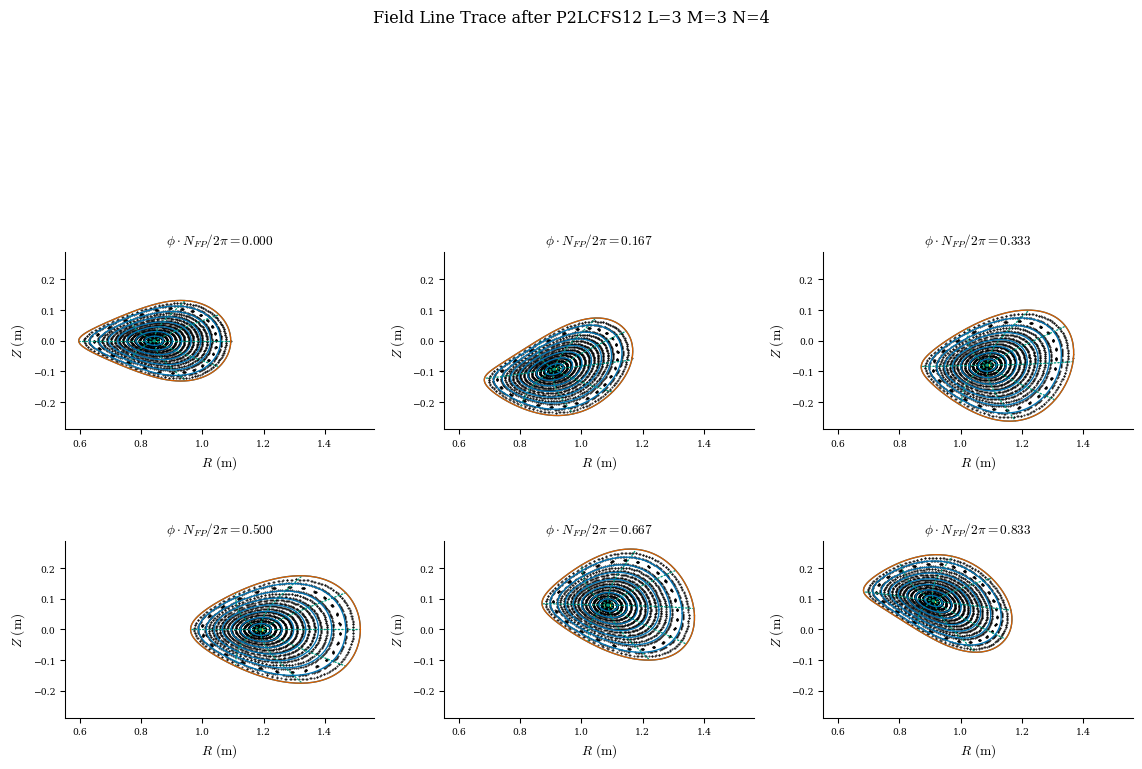

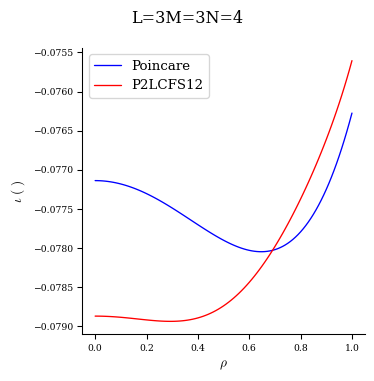

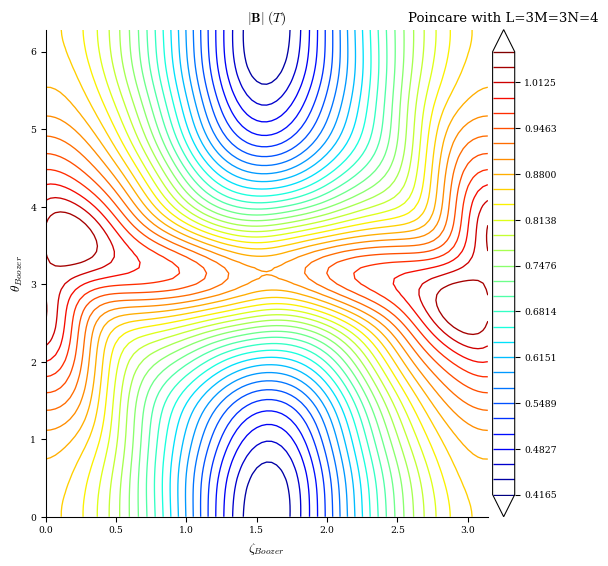

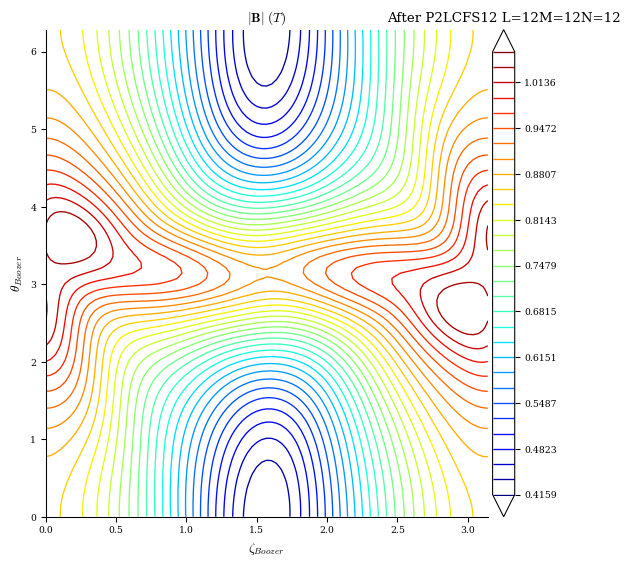

In [11]:
eqi = desc.io.load('eq-poincare/eq-poincare-landreman2021-island-L3M3N4.h5')
eqi._xsection = eqi.get_surface_at(zeta=0)
eqi._surface = eqi.get_surface_at(rho=1)
all_above(eqi)